In [385]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import pickle
import time
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
with open('/home/ngr/gdrive/wearables/data/processed/MOD_1000_Woman_Activity_Data.pkl', 'rb') as f:
    data = pickle.load(f)
    f.close()


# dev

In [152]:
# clean data
print('pid-ga-female for < 1200:')
keys_to_remove = []
counter = 0
for k, v in data.items():
    seq_len = len(v[0])
    if seq_len < 1200:
        counter += 1
        print('  {}\tlen: {}'.format(k, seq_len))
        keys_to_remove.append(k)
print('\n removed {} records'.format(counter))

seq_lengths = []
for k, v in data.items():
    seq_lengths.append(len(v[0]))

if True:
    # actually remove
    for k in keys_to_remove:
        del data[k]

pid-ga-female for < 1200:
  1101-19-1	len: 701
  1227-12-1	len: 636
  1238-25-1	len: 14
  1243-8-1	len: 905
  1325-32-NA	len: 522
  2074-36-1	len: 333
  2214-7-1	len: 633
  2352-16-1	len: 770
  2373-8-1	len: 442
  2455-11-1	len: 185

 removed 10 records


In [182]:
# find min date 
dates = []
for k, v in data.items():
    dates.append(v[0][0])

In [186]:
print('Minimum date in data set: ', min([i.value for i in dates]))

Minimum date in data set:  1485766260000000000


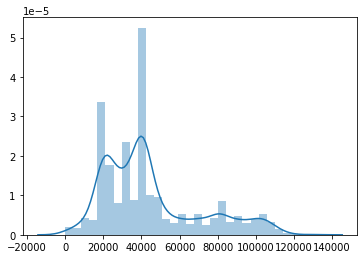

In [149]:
sns.distplot(seq_lengths)

In [193]:
# data loader
class actigraphy(torch.utils.data.Dataset):
    def __init__(self, datapkl, max_seq_len=1200, min_date=1485766260000000000):
        self.datapkl = datapkl
        self.max_seq_len = max_seq_len
        self.min_date = min_date
        
    def __len__(self):
        return len(self.datapkl.keys())

    def __getitem__(self, idx):
        pid = list(self.datapkl.keys())[idx]
        GA = int(pid.split('-')[1])
        t, xt = self.transform(self.datapkl[pid])
        sample = {'x':xt, 'y':torch.tensor(GA), 'tod':torch.tensor(t)}
#         sample = {'x':xt, 'y':torch.tensor(GA), 'tod':t}
        return sample # or (xt, y)
    
    def load_datapkl(self, datapkl_fname):
        '''
        TODO (#enhancement): pass filepath only and internally load data set once called
        '''
        with open(datapkl_fname, 'rb') as f:
            data = pickle.load(f)
            f.close()
        return data
    
    def transform(self, input_seq):
        '''
        TODO (#enhancement): sample different 1200 segments by selecting any starting idx from seq_len - max_length
        '''
        tod = [(i.value - self.min_date)*(1e-9)*(1/60) for i in input_seq[0]] # minutes from min
        activity = torch.FloatTensor(np.array([float(i) for i in input_seq[1]])).view(-1, 1)
        
        if self.max_seq_len is not None:
            tod = tod[:self.max_seq_len] # time of day
            
            activity = activity[:self.max_seq_len, :]

        # log-pseudocount
        '''
        TODO (#enhancement): try different transofmrations or "raw count" embeddings, 
          similar to word_embeddings for vocab size V. embedding_dim
        '''
        activity = activity + 1
        activity = activity.log()

        # alignment
        return (tod, activity)


In [194]:
dataloader = torch.utils.data.DataLoader(actigraphy(data), batch_size=32, shuffle=True)

In [195]:
# dev
batch = next(iter(dataloader))
xt, y, tod = batch['x'], batch['y'], batch['tod']

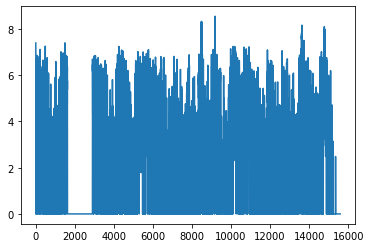

In [86]:
sns.lineplot(np.arange(xt.shape[1]), xt.squeeze())

use time2vec to handle nanosecond representation of time, which should contain information on its own

In [213]:
# periodic activations
def t2v(tau, f, out_features, w, b, w0, b0, arg=None):
    if arg:
        v1 = f(torch.matmul(tau, w) + b, arg)
    else:
        #print(w.shape, t1.shape, b.shape)
        v1 = f(torch.matmul(tau, w) + b)
    v2 = torch.matmul(tau, w0) + b0
    #print(v1.shape)
    return torch.cat([v1, v2], 1)

class SineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(SineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.f = torch.sin

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

class CosineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(CosineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.f = torch.cos

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)
    
    
class time2vec(nn.Module):
    def __init__(self, hidden_dim, output_dim, activation='sin'):
        super().__init__()
        if activation == "sin":
            self.l1 = SineActivation(1, hidden_dim)
        elif activation == "cos":
            self.l1 = CosineActivation(1, hidden_dim)
        
        self.fc1 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.fc1(x)
        return x

In [246]:
t1 = time2vec(1, 4)(tod.view(-1, 1)).view(32, seq_len, 4)
t2 = torch.stack([time2vec(1, 4)(tod[i, :].view(-1, 1)) for i in range(tod.shape[0])])
t1 == t2

In [280]:
input_dim = 1
hidden_size = 32
output_dim = 2
context_size = 4 # minutes
seq_len = 1200

lstm = nn.LSTM(context_size*input_dim, hidden_size)
t_lstm = nn.LSTM(context_size, int(hidden_size/2))
fc1 = nn.Linear(hidden_size, 1)
fc2 = nn.Linear(seq_len - context_size + 1, output_dim)
t_fc1 = nn.Linear(int(hidden_size/2), 1)
t_fc2 = nn.Linear(seq_len, int(output_dim/2))
lin_proj = nn.Linear(int(output_dim/2)+output_dim, output_dim)

# forward
xt.unfold(1, context_size, 1).squeeze().shape
x, hidden = lstm(xt.unfold(1, context_size, 1).squeeze().transpose(0, 1)) # where 1 is batch_size
x = fc1(x.transpose(0, 1))
x = fc2(x.squeeze())
    
tprime = torch.stack([time2vec(1, context_size)(tod[i, :].view(-1, 1)) for i in range(tod.shape[0])])
tprime, _ = t_lstm(tprime.transpose(0, 1))
tprime = t_fc1(tprime.transpose(0, 1))
tprime = t_fc2(tprime.squeeze())

output = lin_proj(torch.cat((x, tprime), -1))
                   

# putting it all together


### pos/neg/anchor loader

In [331]:

# TripletNet data loader 
class GA2wkTriplet(torch.utils.data.Dataset):
    def __init__(self, datapkl, max_seq_len=1200, min_date=1485766260000000000):
        self.datapkl = datapkl
        self.max_seq_len = max_seq_len
        self.min_date = min_date
        
    def __len__(self):
        return len(self.datapkl.keys())

    def __getitem__(self, idx):
        all_pids = list(self.datapkl.keys())
        all_GA = [int(pid.split('-')[1]) for pid in all_pids]
        
        # anchor
        pid = all_pids[idx]
        GA = int(pid.split('-')[1])
        t, xt = self.transform(self.datapkl[pid])
        
        # define pos/neg 
        GArange = (max(0, GA - 2), GA + 2) # weeks
        
        # kick out anchor
        all_pids = [v for i,v in enumerate(all_pids) if i!=idx]
        all_GA = [v for i,v in enumerate(all_GA) if i!=idx]
        
        # pos/neg
        pos_idx = np.random.choice(np.where((np.array(all_GA) >= GArange[0] ) & (np.array(all_GA) <= GArange[1]))[0], 1).item()
        neg_idx = np.random.choice(np.where((np.array(all_GA) < GArange[0] ) | (np.array(all_GA) > GArange[1]))[0], 1).item()
        pos_pid = all_pids[pos_idx]
        neg_pid = all_pids[neg_idx]
        GA_pos = int(pos_pid.split('-')[1])
        t_pos, xt_pos = self.transform(self.datapkl[pos_pid])
        GA_neg = int(neg_pid.split('-')[1])
        t_neg, xt_neg = self.transform(self.datapkl[neg_pid])
        
        sample = {'xt_anchor':xt, 'y_anchor':torch.tensor(GA), 't_anchor':torch.tensor(t),
                  'xt_pos':xt_pos, 'y_pos':torch.tensor(GA_pos), 't_pos':torch.tensor(t_pos),
                 'xt_neg':xt_neg, 'y_neg':torch.tensor(GA_neg), 't_neg':torch.tensor(t_neg),}
        return sample 
    
    def load_datapkl(self, datapkl_fname):
        '''
        TODO (#enhancement): pass filepath only and internally load data set once called
        '''
        with open(datapkl_fname, 'rb') as f:
            data = pickle.load(f)
            f.close()
        return data
    
    def transform(self, input_seq):
        '''
        TODO (#enhancement): sample different 1200 segments by selecting any starting idx from seq_len - max_length
        '''
        tod = [(i.value - self.min_date)*(1e-9)*(1/60) for i in input_seq[0]] # minutes from min
        activity = torch.FloatTensor(np.array([float(i) for i in input_seq[1]])).view(-1, 1)
        
        if self.max_seq_len is not None:
            tod = tod[:self.max_seq_len] # time of day
            
            activity = activity[:self.max_seq_len, :]

        # log-pseudocount
        '''
        TODO (#enhancement): try different transofmrations or "raw count" embeddings, 
          similar to word_embeddings for vocab size V. embedding_dim
        '''
        activity = activity + 1
        activity = activity.log()

        # alignment
        return (tod, activity)


In [332]:
tripletloader = torch.utils.data.DataLoader(GA2wkTriplet(data), batch_size=32, shuffle=True)

## nets

In [347]:
class EmbeddingNet(nn.Module):
    def __init__(self, input_dim=1, hidden_size=32, output_dim=2, context_size=8, seq_len=1200):
        super().__init__()
        self.context_size = context_size
        self.lstm = nn.LSTM(context_size*input_dim, hidden_size)
        self.t_lstm = nn.LSTM(context_size, int(hidden_size/2))
        self.fc1 = nn.Linear(hidden_size, 1)
        self.fc2 = nn.Linear(seq_len - context_size + 1, output_dim)
        self.t_fc1 = nn.Linear(int(hidden_size/2), 1)
        self.t_fc2 = nn.Linear(seq_len, int(output_dim/2))
        self.lin_proj = nn.Linear(int(output_dim/2)+output_dim, output_dim)
        self.time2vec = time2vec(1, context_size)

    def forward(self, xt, t):
        xt, _ = self.lstm(xt.unfold(1, self.context_size, 1).squeeze().transpose(0, 1)) # where 1 is batch_size
        x = F.leaky_relu(self.fc1(xt.transpose(0, 1)))
        x = self.fc2(x.squeeze())

        tprime = torch.stack([self.time2vec(t[i, :].view(-1, 1)) for i in range(t.shape[0])])
        tprime, _ = self.t_lstm(tprime.transpose(0, 1))
        tprime = F.leaky_relu(self.t_fc1(tprime.transpose(0, 1)))
        tprime = self.t_fc2(tprime.squeeze())

        output = self.lin_proj(torch.cat((x, tprime), -1))
        return output

    def get_embedding(self, xt, t):
        return self.forward(xt, t)

class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super().__init__()
        self.embedding_net = embedding_net

    def forward(self, xt_a, t_a, xt_p, t_p, xt_n, t_n):
        output1 = self.embedding_net(xt_a, t_a)
        output2 = self.embedding_net(xt_p, t_p)
        output3 = self.embedding_net(xt_n, t_n)
        return output1, output2, output3

    def get_embedding(self, xt, t):
        return self.embedding_net(xt, t)

## losses

In [348]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

## trainer

In [399]:
model = TripletNet(EmbeddingNet())
loss_fx = TripletLoss(margin=1.)
n_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
loss_per_epoch = []
total_tic = time.time()

for epoch in range(n_epochs):
    
    model.train()
    losses = []
    tic = time.time()
    for batch in tripletloader:
        xt_anc, t_anc = batch['xt_anchor'], batch['t_anchor'] 
        xt_pos, t_pos = batch['xt_pos'], batch['t_pos']   
        xt_neg, t_neg = batch['xt_neg'], batch['t_neg']  

        optimizer.zero_grad()
        outputs = model(xt_anc, t_anc, xt_pos, t_pos, xt_neg, t_neg)
        loss = loss_fx(outputs[0], outputs[1], outputs[2])
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    loss_per_epoch.append(np.mean(losses)) # ave over mini-batches
    print('Epoch {}\t<loss>_mb: {:.4f}\tt_epoch: {:.0f}-s\tt_elapsed: {:.1f}-min'.format(
        epoch+1, np.mean(losses), time.time() - tic, (time.time() - total_tic)/60))
print('Finished training in {:.1f}-h'.format((time.time() - total_tic)/3600))


Epoch 1	<loss>_mb: 1.0009	t_epoch: 272-s	t_elapsed: 4.5-min
Epoch 2	<loss>_mb: 1.0000	t_epoch: 270-s	t_elapsed: 9.0-min
Epoch 3	<loss>_mb: 1.0001	t_epoch: 274-s	t_elapsed: 13.6-min
Epoch 4	<loss>_mb: 1.0001	t_epoch: 274-s	t_elapsed: 18.2-min
Epoch 5	<loss>_mb: 1.0000	t_epoch: 269-s	t_elapsed: 22.7-min
Epoch 6	<loss>_mb: 1.0000	t_epoch: 272-s	t_elapsed: 27.2-min
Epoch 7	<loss>_mb: 1.0000	t_epoch: 306-s	t_elapsed: 32.3-min


## eval

In [ ]:
# get all data in data pkl
class actigraphy(torch.utils.data.Dataset):
    def __init__(self, datapkl, max_seq_len=1200, min_date=1485766260000000000):
        self.datapkl = datapkl
        self.max_seq_len = max_seq_len
        self.min_date = min_date

    def get_all(self):
        pids = list(self.datapkl.keys())
        GAs = np.array([int(pid.split('-')[1]) for pid in pids])
        xt = torch.empty(len(pids), self.max_seq_len, 1)
        t = torch.empty(len(pids), self.max_seq_len, 1)
        for i, pid in enumerate(pids):
            tt, xt[i] = self.transform(self.datapkl[pid])
            t[i] = torch.tensor(np.array(tt)).view(-1, 1)
        sample = {'xt':xt, 'y':torch.tensor(GAs), 't':t}
        return sample 
    
    def load_datapkl(self, datapkl_fname):
        '''
        TODO (#enhancement): pass filepath only and internally load data set once called
        '''
        with open(datapkl_fname, 'rb') as f:
            data = pickle.load(f)
            f.close()
        return data
    
    def transform(self, input_seq):
        '''
        TODO (#enhancement): sample different 1200 segments by selecting any starting idx from seq_len - max_length
        '''
        tod = [(i.value - self.min_date)*(1e-9)*(1/60) for i in input_seq[0]] # minutes from min
        activity = torch.FloatTensor(np.array([float(i) for i in input_seq[1]])).view(-1, 1)
        
        if self.max_seq_len is not None:
            tod = tod[:self.max_seq_len] # time of day
            
            activity = activity[:self.max_seq_len, :]

        # log-pseudocount
        '''
        TODO (#enhancement): try different transofmrations or "raw count" embeddings, 
          similar to word_embeddings for vocab size V. embedding_dim
        '''
        activity = activity + 1
        activity = activity.log()

        # alignment
        return (tod, activity)

In [ ]:
model.eval()
all_actigraphs = actigraphy(data).get_all()
x, y = model.get_embedding(all_actigraphs['xt'], all_actigraphs['t']), all_actigraphs['y']
x = x.detach()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.scatter(x[:, 0], x[:, 1], s=3, c=y, cmap='RdYlBu_r')
cbar = fig.colorbar(im)
cbar.set_label('GA (weeks)', rotation=270)
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_title('TripletNet for GA range within 2wk')